<a href="https://colab.research.google.com/github/AkliYalaoui/Deceptive-Opinion-Spam-Classification/blob/main/Attention_based_Bidirectional_LSTM_for_Deceptive_Opinion_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
import re
import string
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn import preprocessing

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
data_train = pd.read_csv('/content/drive/MyDrive/yelp_data/train.csv',header=None)

In [6]:
data_train.columns = ['deceptive','text']

In [7]:
data_train.head(5)

,deceptive,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [8]:
from sklearn import preprocessing

In [9]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
data_train['deceptive']= label_encoder.fit_transform(data_train['deceptive'])

data_train['deceptive'].unique()


array([0, 1])

In [10]:
target_column = 'deceptive'

# Sample the same number of instances from each class
data_train = data_train.groupby(target_column, group_keys=False).apply(lambda x: x.sample(800))


In [11]:
#dataset description
data_train.groupby('deceptive').describe()

text                                                               
          count unique                                                top freq
deceptive                                                                     
0           800    800  Pedicure was ok .. Don't waste the money on th...    1
1           800    800  I may not have much experience buying mattress...    1

# 3. Deep Learning Architectures

### A. CNN + LSTM + Doc2Vec +TF-IDF

In [12]:
! pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=0f15eab6e59fc948fa42f408f4201e8bd727b6bd85b62ef11351667ef9e5a914
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [13]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
from keras.layers import Embedding
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from keras.models import Model, Sequential
import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models import doc2vec
from gensim.models import KeyedVectors
import itertools, nltk, snowballstemmer, re

LabeledSentence = doc2vec.TaggedDocument

In [14]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources

        flipped = {}

        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')

    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])

    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences

    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [15]:
data =data_train

In [16]:
#data['polarity'] = np.where(data['polarity']=='positive', 1, 0)
#data['deceptive'] = np.where(data['deceptive']=='truthful', 1, 0)

In [17]:
data.head()

,deceptive,text
45703,0,Pedicure was ok .. Don't waste the money on th...
453198,0,Nothing like Capriotti's in other cities. The...
439365,0,"Tacos are my favorite food, but instead of bei..."
450643,0,We went to this cute little yogurt store for i...
33837,0,This Pizza Hut location has poor customer serv...


In [18]:
df = data.sample(frac=1)
df.head()

,deceptive,text
374798,0,"OMG if it wasn't for our insurance, we will ne..."
159236,1,Been here a few times in the last couple years...
195157,1,Back again! I'm so happy we have some friends...
496734,1,"Friendly staff, relaxed atmosphere,and healthy..."
37836,1,My 10 y/o daughter was seen by a DPM and Foot ...


In [19]:
df.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [20]:
#def create_class(c):
#    if c['polarity'] == 1 and c['deceptive'] == 1:
#        return [1,1]
#    elif c['polarity'] == 1 and c['deceptive'] == 0:
#        return [1,0]
#    elif c['polarity'] == 0 and c['deceptive'] == 1:
#        return [0,1]
#    else:
#        return [0,0]
#
#def specific_class(c):
#    if c['polarity'] == 1 and c['deceptive'] == 1:
#        return "TRUE_POSITIVE"
#    elif c['polarity'] == 1 and c['deceptive'] == 0:
#        return "FALSE_POSITIVE"
#    elif c['polarity'] == 0 and c['deceptive'] == 1:
#        return "TRUE_NEGATIVE"
#    else:
#        return "FALSE_NEGATIVE"
#
#data['final_class'] = data.apply(create_class, axis=1)
#data['given_class'] = data.apply(specific_class, axis=1)

In [21]:
#data.head()

In [22]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
data['deceptive']= label_encoder.fit_transform(data['deceptive'])

data['deceptive'].unique()

array([0, 1])

In [23]:
from tensorflow.keras.utils import to_categorical

Y = data['deceptive']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [24]:
textData = pd.DataFrame(list(data['text']))

stemmer = snowballstemmer.EnglishStemmer()

# grab stopword list, extend it a bit, and then turn it into a set for later
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [25]:
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]


In [26]:
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]


In [27]:
lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

def label_sentences(df, input_point):
    labeled_sentences = []
    list_sen = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint[input_point].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
        list_sen.append(tokenized_words)
    return labeled_sentences, list_sen

def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1, window=9, vector_size=512, sample=1e-4, negative=5, workers=7)
    model.build_vocab(labeled_sentences)
    pretrained_weights = model.wv.vectors
    vocab_size, embedding_size = pretrained_weights.shape
    model.train(labeled_sentences, total_examples=vocab_size, epochs=400)

    return model

In [28]:
textData = data['stemmed_text_data'].to_frame().reset_index()
sen, corpus = label_sentences(textData, 'stemmed_text_data')

In [29]:
doc2vec_model = train_doc2vec_model(sen)

In [30]:
doc2vec_model.save("doc2vec_model_opinion_corpus.d2v")

In [31]:
doc2vec_model = Doc2Vec.load("doc2vec_model_opinion_corpus.d2v")

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf1 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,1))
result_train1 = tfidf1.fit_transform(corpus)

tfidf2 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,2))
result_train2 = tfidf2.fit_transform(corpus)

tfidf3 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,3))
result_train3 = tfidf3.fit_transform(corpus)

svd = TruncatedSVD(n_components=512, n_iter=40, random_state=34)
tfidf_data1 = svd.fit_transform(result_train1)
tfidf_data2 = svd.fit_transform(result_train2)
tfidf_data3 = svd.fit_transform(result_train3)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy

nlp = spacy.load('en_core_web_sm')
temp_textData = pd.DataFrame(list(data['text']))

overall_pos_tags_tokens = []
overall_pos = []
overall_tokens = []
overall_dep = []

for i in range(1600):
    doc = nlp(temp_textData[0][i])
    given_pos_tags_tokens = []
    given_pos = []
    given_tokens = []
    given_dep = []
    for token in doc:
        output = "%s_%s" % (token.pos_, token.tag_)
        given_pos_tags_tokens.append(output)
        given_pos.append(token.pos_)
        given_tokens.append(token.tag_)
        given_dep.append(token.dep_)

    overall_pos_tags_tokens.append(given_pos_tags_tokens)
    overall_pos.append(given_pos)
    overall_tokens.append(given_tokens)
    overall_dep.append(given_dep)

In [34]:
from sklearn.preprocessing import MinMaxScaler

count = CountVectorizer(tokenizer=lambda i:i, lowercase=False)
pos_tags_data = np.asarray(count.fit_transform(overall_pos_tags_tokens).todense())
pos_data = np.asarray(count.fit_transform(overall_pos).todense())
tokens_data = np.asarray(count.fit_transform(overall_tokens).todense())
dep_data = np.asarray(count.fit_transform(overall_dep).todense())
min_max_scaler = MinMaxScaler()
normalized_pos_tags_data = min_max_scaler.fit_transform(pos_tags_data)
normalized_pos_data = min_max_scaler.fit_transform(pos_data)
normalized_tokens_data = min_max_scaler.fit_transform(tokens_data)
normalized_dep_data = min_max_scaler.fit_transform(dep_data)

final_pos_tags_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_tokens_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_dep_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_tags_data[:normalized_pos_tags_data.shape[0],:normalized_pos_tags_data.shape[1]] = normalized_pos_tags_data
final_pos_data[:normalized_pos_data.shape[0],:normalized_pos_data.shape[1]] = normalized_pos_data
final_tokens_data[:normalized_tokens_data.shape[0],:normalized_tokens_data.shape[1]] = normalized_tokens_data
final_dep_data[:normalized_dep_data.shape[0],:normalized_dep_data.shape[1]] = normalized_dep_data

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
pos_tags_data

array([[ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  8,  0, ...,  0,  0,  0],
       [ 0, 36,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  8,  0, ...,  0,  0,  0],
       [ 0, 15,  1, ...,  0,  0,  0]])

In [36]:
maxlength = []
for i in range(0,len(sen)):
    maxlength.append(len(sen[i][0]))

print(max(maxlength))

408


In [37]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.dv[label])
    df['vectorized_comments'] = comments

    return df

textData = vectorize_comments(textData,doc2vec_model)
print (textData.head(2))

    index                                  stemmed_text_data  \
0   45703  pedicur ok wast money leg messag could even te...   
1  453198  noth like capriotti citi menu offer east coast...   

                                 vectorized_comments  
0  [0.17928185, 0.0746264, 0.07162935, -0.1581574...  
1  [-0.067388445, -0.40405196, -0.35104868, -0.42...  


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(textData["vectorized_comments"].T.tolist(),
                                                                     dummy_y,
                                                                     test_size=0.1,
                                                                     random_state=56)

In [39]:
X = np.array(textData["vectorized_comments"].T.tolist()).reshape((1,1600,512))
y = np.array(dummy_y).reshape((1600,2))
X_train2 = np.array(X_train).reshape((1,1440,512))
y_train2 = np.array(y_train).reshape((1,1440,2))
X_test2 = np.array(X_test).reshape((1,160,512))
y_test2 = np.array(y_test).reshape((1,160,2))

In [40]:
from sklearn.model_selection import StratifiedKFold
Xtemp = textData["vectorized_comments"].T.tolist()
ytemp = data['deceptive']
training_indices = []
testing_indices = []

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(Xtemp, ytemp)

for train_index, test_index in skf.split(Xtemp, ytemp):
    training_indices.append(train_index)
    testing_indices.append(test_index)

In [41]:
def extractTrainingAndTestingData(givenIndex):
    X_train3 = np.zeros(shape=(1440, max(maxlength)+10, 512)).astype(np.float32)
    Y_train3 = np.zeros(shape=(1440, 2)).astype(np.float32)
    X_test3 = np.zeros(shape=(160, max(maxlength)+10, 512)).astype(np.float32)
    Y_test3 = np.zeros(shape=(160, 2)).astype(np.float32)

    empty_word = np.zeros(512).astype(np.float32)

    count_i = 0
    for i in training_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_train3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_train3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_train3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_train3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_train3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_train3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_train3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_train3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_train3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_train3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_train3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_train3[count_i,j,:] = final_dep_data[i]
            else:
                X_train3[count_i,j,:] = empty_word

        Y_train3[count_i,:] = dummy_y[i]
        count_i += 1


    count_i = 0
    for i in testing_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_test3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_test3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_test3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_test3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_test3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_test3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_test3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_test3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_test3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_test3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_test3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_test3[count_i,j,:] = final_dep_data[i]
            else:
                X_test3[count_i,j,:] = empty_word

        Y_test3[count_i,:] = dummy_y[i]
        count_i += 1

    return X_train3, X_test3, Y_train3, Y_test3

In [42]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9, padding='same', activation='relu', input_shape=(max(maxlength)+10,512)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(50, dropout=0.25, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 418, 128)          589952    
                                                                 
 dropout (Dropout)           (None, 418, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 209, 128)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 209, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 209, 128)          114816    
                                                                 
 dropout_2 (Dropout)         (None, 209, 128)          0         
                                                        

In [43]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint

final_accuracies = []

filename = 'weights.best.from_scratch%s.hdf5' % 9
checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(9)

In [44]:
history = model.fit(X_train3, Y_train3, epochs=15, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3), verbose=1)

Epoch 1/15
3/3 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5562
Epoch 1: val_loss improved from inf to 0.67833, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 26s 5s/step - loss: 0.6916 - accuracy: 0.5562 - val_loss: 0.6783 - val_accuracy: 0.5063
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.6549
Epoch 2: val_loss improved from 0.67833 to 0.54272, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.6450 - accuracy: 0.6549 - val_loss: 0.5427 - val_accuracy: 0.8125
Epoch 3/15
3/3 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7986
Epoch 3: val_loss improved from 0.54272 to 0.45531, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 4s 1s/step - loss: 0.5323 - accuracy: 0.7986 - val_loss: 0.4553 - val_accuracy: 0.8188
Epoch 4/15
3/3 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8278
Epoch 4: val_loss improved from 0.45531 to 0.41891, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 4s 1s/step - loss: 0.4405 - accuracy: 0.8278 - val_loss: 0.4189 - val_accuracy: 0.8313
Epoch 5/15
3/3 [==============================] - ETA: 0s

In [45]:
model.evaluate(X_test3, Y_test3)

5/5 [==============================] - 1s 135ms/step - loss: 0.5026 - accuracy: 0.8438


[0.5025900602340698, 0.84375]

In [46]:
import matplotlib.pyplot as plt

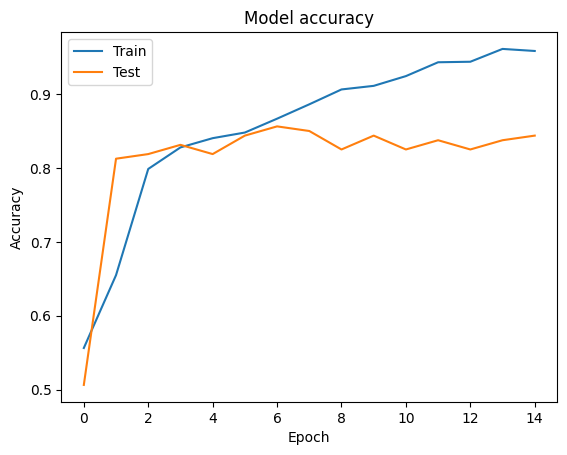

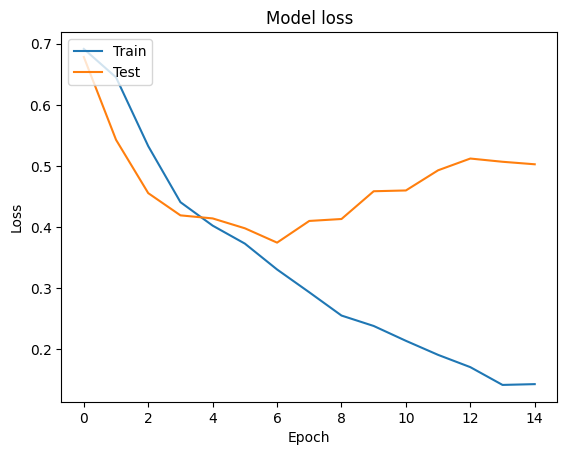

In [47]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [51]:
train_loss, train_accuracy = model.evaluate(X_train3, Y_train3, verbose=0)
print("Train Accuracy:", train_accuracy)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test3, Y_test3, verbose=0)
print("Test Accuracy:", test_accuracy)


paper_results = {
    "Model" : [ "CNN + LSTM + Doc2Vec +TF-IDF"],
    "Train accuracy" : [ 0.8257 ],
    "Test accuracy": [ 0.8000 ]
}

yelp_results= {
    "Model" : ["CNN + LSTM + Doc2Vec +TF-IDF"],
    "Train accuracy" : [train_accuracy],
    "Test accuracy": [ test_accuracy]
}



Train Accuracy: 0.9652777910232544
Test Accuracy: 0.84375


#results

In [52]:
pd.DataFrame(yelp_results)

,Model,Train accuracy,Test accuracy
0,CNN + LSTM + Doc2Vec +TF-IDF,0.965278,0.84375


In [53]:
pd.DataFrame(paper_results)

,Model,Train accuracy,Test accuracy
0,CNN + LSTM + Doc2Vec +TF-IDF,0.8257,0.8
